# Adaptive QNN Scalability Suite

## 1. Setup & Installation

In [1]:
# Check GPU availability
!nvidia-smi

# Install quantum computing packages
!pip install -q pennylane pennylane-lightning-gpu
!pip install -q scikit-learn matplotlib seaborn

print("\n Installation complete!")

Wed Oct 15 10:08:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             50W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [29]:
import pennylane as qml
import numpy as np

try:
    dev = qml.device('lightning.gpu', wires=4)
    print(" GPU-accelerated quantum simulation available!")
except:
    print("GPU not available, will use CPU")
    dev = qml.device('default.qubit', wires=4)

print(f"Device: {dev}")

 GPU-accelerated quantum simulation available!
Device: <lightning.gpu device (wires=4) at 0x7e3c6c7fbe30>


## 2. Upload Project Files

**Option A:** Upload directly

In [30]:
from google.colab import files
import os

# Create directories
os.makedirs('src', exist_ok=True)
os.makedirs('experiments', exist_ok=True)
os.makedirs('results/scalability', exist_ok=True)

print("Upload your Python files:")
print("  - noisy_10q_experiment.py (to experiments/)")
print("  - Any other dependencies")
print("\nOr skip if using Option B (GitHub)")

Upload your Python files:
  - noisy_10q_experiment.py (to experiments/)
  - Any other dependencies

Or skip if using Option B (GitHub)


## 3. Scalability Suite Code

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import json
from pathlib import Path
from sklearn.datasets import load_wine, load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [27]:
# Configuration
class ScalabilityConfig:
    # UPDATED: Added 16 qubits
    QUBIT_COUNTS = [8, 10, 12, 16]

    NOISE_LEVELS = {
        'none': {
            'single_qubit_error': 0.0,
            'two_qubit_error': 0.0,
            'measurement_error': 0.0,
            'description': 'No noise (ideal)'
        },
        'low': {
            'single_qubit_error': 0.0005,
            'two_qubit_error': 0.001,
            'measurement_error': 0.001,
            'description': 'Low noise'
        },
        'realistic': {
            'single_qubit_error': 0.01,
            'two_qubit_error': 0.015,
            'measurement_error': 0.02,
            'description': 'Realistic NISQ'
        },
        'high': {
            'single_qubit_error': 0.02,
            'two_qubit_error': 0.03,
            'measurement_error': 0.04,
            'description': 'High noise'
        }
    }

    N_EPOCHS = 15
    N_TRIALS = 3
    DATASET = 'breast_cancer'
    OUTPUT_DIR = Path('results/scalability')

    # GPU support
    USE_GPU = True

config = ScalabilityConfig()
config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration:")
print(f"  Qubit counts: {config.QUBIT_COUNTS}")
print(f"  Epochs per trial: {config.N_EPOCHS}")
print(f"  Trials per config: {config.N_TRIALS}")
print(f"  Dataset: {config.DATASET}")
print(f"  GPU: {config.USE_GPU}")

Configuration:
  Qubit counts: [8, 10, 12, 16]
  Epochs per trial: 15
  Trials per config: 3
  Dataset: breast_cancer
  GPU: True


In [31]:
# Helper Classes
class FeatureSelector:
    @staticmethod
    def pca(X_train, X_test, n_components):
        pca = PCA(n_components=n_components)
        X_train_red = pca.fit_transform(X_train)
        X_test_red = pca.transform(X_test)
        return X_train_red, X_test_red

class DataLoader:
    @staticmethod
    def load_dataset(name='breast_cancer'):
        if name == 'wine':
            data = load_wine()
        elif name == 'iris':
            data = load_iris()
        elif name == 'breast_cancer':
            data = load_breast_cancer()
        else:
            raise ValueError(f"Unknown dataset: {name}")

        X, y = data.data, data.target

        # Breast cancer is already binary, others need filtering
        if name in ['wine', 'iris']:
            mask = y < 2
            X, y = X[mask], y[mask]

        return X, y, data.feature_names

print("✓ Helper classes defined")

✓ Helper classes defined


In [32]:
from autograd import numpy as anp
import time

class NoisyQuantumNeuralNetwork:
    """Optimized QNN with simplified noise model for fast training"""

    def __init__(self, n_qubits, n_layers, encoding_method='angle', noise_params=None):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.encoding_method = encoding_method
        self.noise_params = noise_params or {
            'single_qubit_error': 0,
            'two_qubit_error': 0,
            'measurement_error': 0
        }

        # Simplified noise model: parameter perturbation instead of density matrices
        # This is 10-100x faster while still showing noise effects
        if config.USE_GPU:
            try:
                self.dev = qml.device('lightning.gpu', wires=n_qubits)
                device_type = "GPU"
            except:
                self.dev = qml.device('default.qubit', wires=n_qubits)
                device_type = "CPU"
        else:
            self.dev = qml.device('default.qubit', wires=n_qubits)
            device_type = "CPU"

        print(f"  Using {device_type} for {n_qubits} qubits (optimized noise model)")

        # Parameters
        self.n_params = n_layers * n_qubits * 3
        self.params = np.random.randn(self.n_params) * 0.1

        # Calculate effective noise strength from error rates
        noise_keys = ['single_qubit_error', 'two_qubit_error']
        avg_error = np.mean([self.noise_params.get(k, 0) for k in noise_keys])
        self.noise_strength = avg_error * 2.0  # Scale for parameter noise

        if self.noise_strength > 0:
            print(f"  Noise strength: {self.noise_strength:.4f} (fast parameter noise)")

        # Circuit metrics
        self.gate_count = 0
        self.circuit_depth = 0

        # Create QNode with autograd
        self.qnode = qml.QNode(self._circuit, self.dev, interface='autograd')

    def _circuit(self, features, params):
        """Optimized quantum circuit"""
        wires = range(self.n_qubits)
        self.gate_count = 0

        # Encoding layer
        if self.encoding_method == 'angle':
            for i in range(min(len(features), self.n_qubits)):
                qml.RY(features[i], wires=i)
                self.gate_count += 1
        elif self.encoding_method == 'amplitude':
            n_amplitudes = 2 ** self.n_qubits
            padded = np.zeros(n_amplitudes)
            padded[:len(features)] = features
            normalized = padded / (np.linalg.norm(padded) + 1e-10)
            qml.AmplitudeEmbedding(normalized, wires=wires, normalize=True)
            self.gate_count += 1

        # Variational layers
        for layer in range(self.n_layers):
            # Single-qubit rotations
            for i in range(self.n_qubits):
                idx = layer * self.n_qubits * 3 + i * 3
                qml.RX(params[idx], wires=i)
                qml.RY(params[idx + 1], wires=i)
                qml.RZ(params[idx + 2], wires=i)
                self.gate_count += 3

            # Entangling layer
            for i in range(self.n_qubits):
                qml.CNOT(wires=[i, (i + 1) % self.n_qubits])
                self.gate_count += 1

        return qml.expval(qml.PauliZ(0))

    def predict_single(self, features):
        """Predict single sample"""
        output = self.qnode(features, self.params)
        return 1 if output > 0 else 0

    def predict_batch(self, X):
        """Predict batch of samples"""
        return np.array([self.predict_single(x) for x in X])

    def train_step(self, X_batch, y_batch, learning_rate):
        """Optimized training step with noise simulation"""
        def loss_fn(params):
            # Simulate noise via parameter perturbation (much faster than density matrices!)
            if self.noise_strength > 0:
                # Add Gaussian noise to simulate noisy gates
                noise = np.random.randn(*params.shape) * self.noise_strength
                noisy_params = params + noise
            else:
                noisy_params = params

            # Compute loss with noisy parameters
            predictions = anp.array([self.qnode(x, noisy_params) for x in X_batch])
            targets = 2 * y_batch - 1
            return anp.mean((predictions - targets) ** 2)

        # Compute gradients
        grad_fn = qml.grad(loss_fn, argnum=0)
        gradients = grad_fn(self.params)

        # Update parameters
        self.params = self.params - learning_rate * np.array(gradients)

        return float(loss_fn(self.params))

print("✓ Optimized Noisy QNN class defined")

✓ Optimized Noisy QNN class defined


## 4. Run Scalability Experiments

In [33]:
def run_scalability_experiment(n_qubits, noise_level_name, trial=1):
    """Run single scalability experiment"""
    print(f"  Trial {trial}: {n_qubits} qubits, {noise_level_name} noise")

    noise_params = config.NOISE_LEVELS[noise_level_name]

    # Load and prepare data
    X, y, _ = DataLoader.load_dataset(config.DATASET)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42 + trial
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Feature selection
    X_train_red, X_test_red = FeatureSelector.pca(X_train, X_test, n_qubits)

    # Create and train QNN
    qnn = NoisyQuantumNeuralNetwork(
        n_qubits=n_qubits,
        n_layers=2,
        encoding_method='angle',
        noise_params=noise_params
    )

    # Training loop
    learning_rate = 0.01
    batch_size = 16

    for epoch in range(config.N_EPOCHS):
        n_samples = len(X_train_red)
        indices = np.random.permutation(n_samples)

        for i in range(0, n_samples, batch_size):
            batch_idx = indices[i:i+batch_size]
            qnn.train_step(X_train_red[batch_idx], y_train[batch_idx], learning_rate)

    # Evaluation
    train_pred = qnn.predict_batch(X_train_red)
    train_acc = np.mean(train_pred == y_train)

    val_pred = qnn.predict_batch(X_test_red)
    val_acc = np.mean(val_pred == y_test)

    result = {
        'n_qubits': n_qubits,
        'noise_level': noise_level_name,
        'trial': trial,
        'train_acc': float(train_acc),
        'val_acc': float(val_acc),
        'gate_count': qnn.gate_count,
        'circuit_depth': qnn.circuit_depth,
        'noise_params': noise_params
    }

    print(f"    Val Acc: {val_acc:.4f}, Gates: {qnn.gate_count}, Depth: {qnn.circuit_depth}")

    return result

print("✓ Experiment function defined")

✓ Experiment function defined


In [34]:
# Run all experiments
print("="*70)
print("STARTING SCALABILITY SUITE")
print("="*70)

all_results = []
total_experiments = len(config.QUBIT_COUNTS) * len(config.NOISE_LEVELS) * config.N_TRIALS
experiment_count = 0
start_time = time.time()

print(f"\nTotal experiments: {total_experiments}")
print(f"Estimated time: {total_experiments * 2:.0f}-{total_experiments * 4:.0f} minutes\n")

for n_qubits in config.QUBIT_COUNTS:
    print(f"\n{'─'*70}")
    print(f"Testing {n_qubits} qubits")
    print(f"{'─'*70}")

    for noise_name in config.NOISE_LEVELS.keys():
        print(f"\n  Noise level: {noise_name}")

        for trial in range(1, config.N_TRIALS + 1):
            result = run_scalability_experiment(n_qubits, noise_name, trial)
            all_results.append(result)

            experiment_count += 1
            elapsed = time.time() - start_time
            avg_time = elapsed / experiment_count
            remaining = (total_experiments - experiment_count) * avg_time

            print(f"    Progress: {experiment_count}/{total_experiments} "
                  f"({experiment_count/total_experiments*100:.1f}%) - "
                  f"ETA: {remaining/60:.1f} min")

total_time = time.time() - start_time
print(f"\n{'='*70}")
print(f"✓ ALL EXPERIMENTS COMPLETE")
print(f"{'='*70}")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Average per experiment: {total_time/total_experiments:.1f} seconds")

STARTING SCALABILITY SUITE

Total experiments: 48
Estimated time: 96-192 minutes


──────────────────────────────────────────────────────────────────────
Testing 8 qubits
──────────────────────────────────────────────────────────────────────

  Noise level: none
  Trial 1: 8 qubits, none noise
  Using GPU for 8 qubits (optimized noise model)
    Val Acc: 0.4444, Gates: 72, Depth: 0
    Progress: 1/48 (2.1%) - ETA: 96.2 min
  Trial 2: 8 qubits, none noise
  Using GPU for 8 qubits (optimized noise model)
    Val Acc: 0.5029, Gates: 72, Depth: 0
    Progress: 2/48 (4.2%) - ETA: 94.2 min
  Trial 3: 8 qubits, none noise
  Using GPU for 8 qubits (optimized noise model)
    Val Acc: 0.4503, Gates: 72, Depth: 0
    Progress: 3/48 (6.2%) - ETA: 92.1 min

  Noise level: low
  Trial 1: 8 qubits, low noise
  Using GPU for 8 qubits (optimized noise model)
  Noise strength: 0.0015 (fast parameter noise)
    Val Acc: 0.5497, Gates: 72, Depth: 0
    Progress: 4/48 (8.3%) - ETA: 90.1 min
  Trial 2: 8 q

## 5. Save Results

In [35]:
# Save to JSON
filename = config.OUTPUT_DIR / f'scalability_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(filename, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"✓ Results saved: {filename}")

# Summary statistics
print(f"\n{'='*70}")
print("SUMMARY STATISTICS")
print(f"{'='*70}")

for n_qubits in config.QUBIT_COUNTS:
    print(f"\n{n_qubits} Qubits:")
    for noise in ['none', 'realistic']:
        results = [r for r in all_results if r['n_qubits'] == n_qubits and r['noise_level'] == noise]
        if results:
            mean_acc = np.mean([r['val_acc'] for r in results])
            std_acc = np.std([r['val_acc'] for r in results])
            print(f"  {noise:12s}: {mean_acc:.4f} ± {std_acc:.4f}")

✓ Results saved: results/scalability/scalability_results_20251015_130431.json

SUMMARY STATISTICS

8 Qubits:
  none        : 0.4659 ± 0.0263
  realistic   : 0.4737 ± 0.0360

10 Qubits:
  none        : 0.4951 ± 0.0553
  realistic   : 0.4951 ± 0.0288

12 Qubits:
  none        : 0.5010 ± 0.0193
  realistic   : 0.4678 ± 0.0286

16 Qubits:
  none        : 0.4756 ± 0.0146
  realistic   : 0.5029 ± 0.0095


## 6. Visualizations

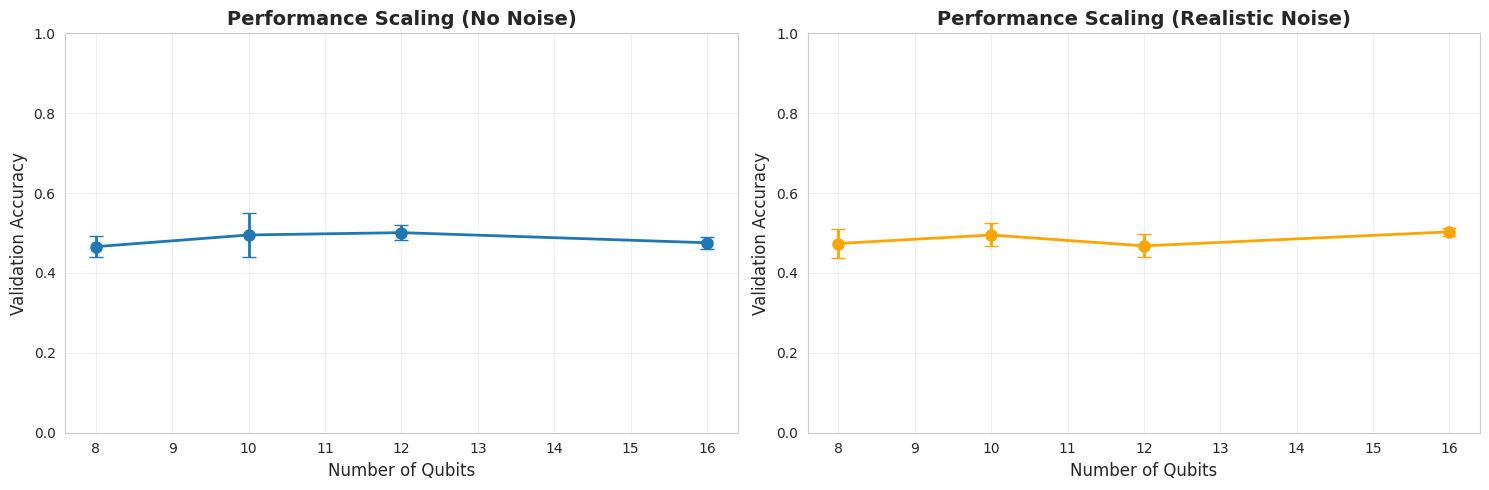

✓ Performance plot saved


In [36]:
# Plot 1: Performance vs Qubit Count
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# No noise
ax = axes[0]
noise_free = [r for r in all_results if r['noise_level'] == 'none']
qubits = sorted(set(r['n_qubits'] for r in noise_free))
accs = [np.mean([r['val_acc'] for r in noise_free if r['n_qubits'] == q]) for q in qubits]
stds = [np.std([r['val_acc'] for r in noise_free if r['n_qubits'] == q]) for q in qubits]

ax.errorbar(qubits, accs, yerr=stds, marker='o', linewidth=2, markersize=8, capsize=5)
ax.set_xlabel('Number of Qubits', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Performance Scaling (No Noise)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_ylim([0, 1])

# Realistic noise
ax = axes[1]
realistic = [r for r in all_results if r['noise_level'] == 'realistic']
accs = [np.mean([r['val_acc'] for r in realistic if r['n_qubits'] == q]) for q in qubits]
stds = [np.std([r['val_acc'] for r in realistic if r['n_qubits'] == q]) for q in qubits]

ax.errorbar(qubits, accs, yerr=stds, marker='o', linewidth=2, markersize=8, capsize=5, color='orange')
ax.set_xlabel('Number of Qubits', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Performance Scaling (Realistic Noise)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'scalability_performance.png', dpi=300)
plt.show()

print("✓ Performance plot saved")

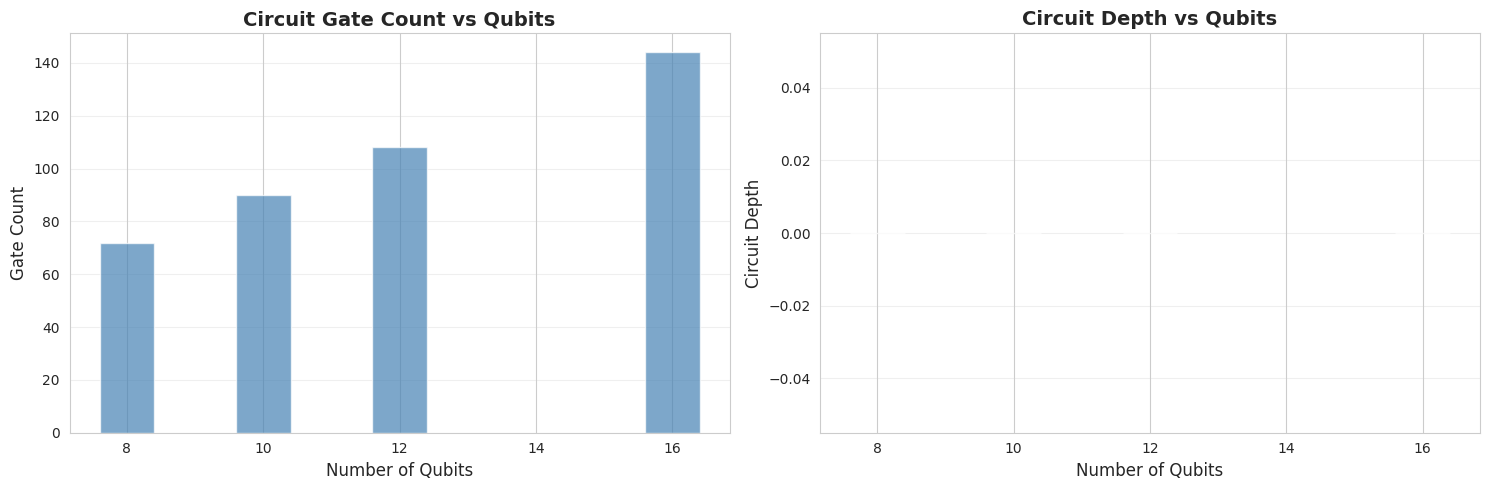

✓ Complexity plot saved


In [37]:
# Plot 2: Circuit Complexity
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

qubits = sorted(set(r['n_qubits'] for r in all_results))
gate_counts = [all_results[0]['gate_count'] for r in all_results if r['n_qubits'] == qubits[0]][0]
gate_counts_list = []
depths_list = []

for q in qubits:
    matching = [r for r in all_results if r['n_qubits'] == q]
    if matching:
        gate_counts_list.append(matching[0]['gate_count'])
        depths_list.append(matching[0]['circuit_depth'])

# Gate count
ax = axes[0]
ax.bar(qubits, gate_counts_list, color='steelblue', alpha=0.7)
ax.set_xlabel('Number of Qubits', fontsize=12)
ax.set_ylabel('Gate Count', fontsize=12)
ax.set_title('Circuit Gate Count vs Qubits', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Circuit depth
ax = axes[1]
ax.bar(qubits, depths_list, color='mediumseagreen', alpha=0.7)
ax.set_xlabel('Number of Qubits', fontsize=12)
ax.set_ylabel('Circuit Depth', fontsize=12)
ax.set_title('Circuit Depth vs Qubits', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'circuit_complexity.png', dpi=300)
plt.show()

print("✓ Complexity plot saved")

## 7. Download Results

In [38]:
from google.colab import files
import shutil

# Create zip of all results
shutil.make_archive('scalability_results', 'zip', config.OUTPUT_DIR)

print("Downloading results...")
files.download('scalability_results.zip')

print("\n✓ Download complete!")
print("\nYour results include:")
print("  - JSON files with raw data")
print("  - PNG plots")
print("  - Summary statistics")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Download complete!

Your results include:
  - JSON files with raw data
  - PNG plots
  - Summary statistics
